<a href="https://colab.research.google.com/github/moham6839/Data_620_Week_10_Assignment/blob/main/Data_620_Week_Ten_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data 620 Web Analytics

Week Ten - Assignment: Document Classification






Said Naqwe

Eddie Xu

Mohamed Hassan-El Serafi



# Instructions


It can be useful to be able to classify new "test" documents using already classified "training" documents. A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam. Here is one example of such data: UCI Machine Learning Repository: Spambase Data Set http://archive.ics.uci.edu/ml/datasets/Spambase

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

# Introduction

As a virtual team, we’ve collaborated to build a classifier, enhancing our data science expertise initially targeting name gender prediction. For this demonstration, we’ve adapted our approach to the SMS Spam Collection dataset, with 5,572 messages, sourced via KaggleHub in Google Colab. The dataset can also be found on the Kaggle website: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset. Using Naive Bayes and engineered features like message length, we optimized performance across training and test sets. In this presentation, we’ll outline our methodology, showcase our code, and share our results. Let’s get started





# Libraries/Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import string
import kagglehub
import random
%matplotlib inline
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

#set seed for recreation
random.seed(620)

path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")
print("Path to dataset files:", path)


file_path = path + "/spam.csv"
messages = pd.read_csv(file_path, encoding='latin-1')
print("Total number of messages:", len(messages))
print("First message sneak peek:", messages.iloc[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


100%|██████████| 211k/211k [00:00<00:00, 39.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1
Total number of messages: 5572
First message sneak peek: v1                                                          ham
v2            Go until jurong point, crazy.. Available only ...
Unnamed: 2                                                  NaN
Unnamed: 3                                                  NaN
Unnamed: 4                                                  NaN
Name: 0, dtype: object


# Data Cleaning

In [2]:
# Fix it to match your snippet—rename columns and add length
messages = messages[['v1', 'v2']]  # Kaggle’s got v1 (label), v2 (text)
messages.columns = ["label", "message"]  # Match your setup
messages['length'] = messages['message'].apply(len)  # Add that length column
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [3]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

# Exploratory Data Analysis

In [4]:
messages["No_of_Words"] = messages.apply(lambda row: nltk.tokenize.word_tokenize(row['message']), axis=1).apply(len)
messages["No_of_sentence"] = messages.apply(lambda row: nltk.tokenize.sent_tokenize(row['message']), axis=1).apply(len)

messages.describe().T

,count,mean,std,min,25%,50%,75%,max
length,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


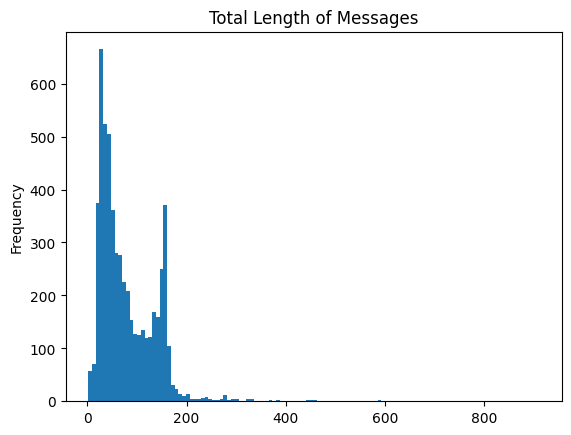

In [5]:
messages['length'].plot(bins=120, kind='hist')
plt.title("Total Length of Messages")
plt.show()

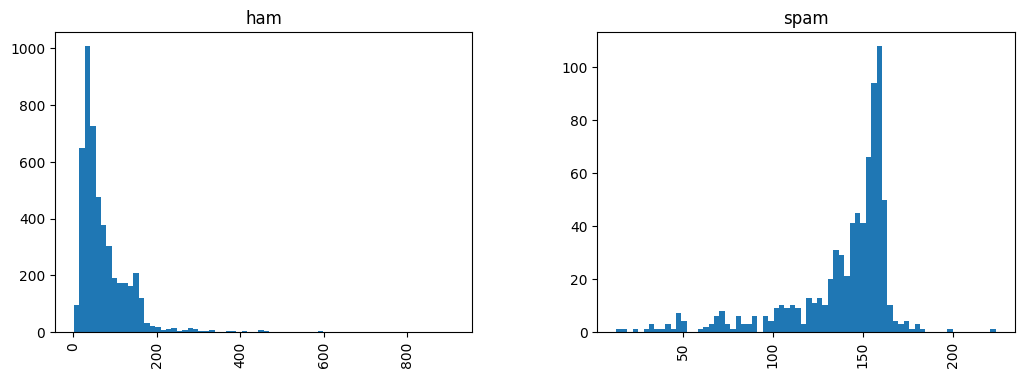

In [6]:
messages.hist(column='length', by='label', bins=70,figsize=(12,4))
plt.show()

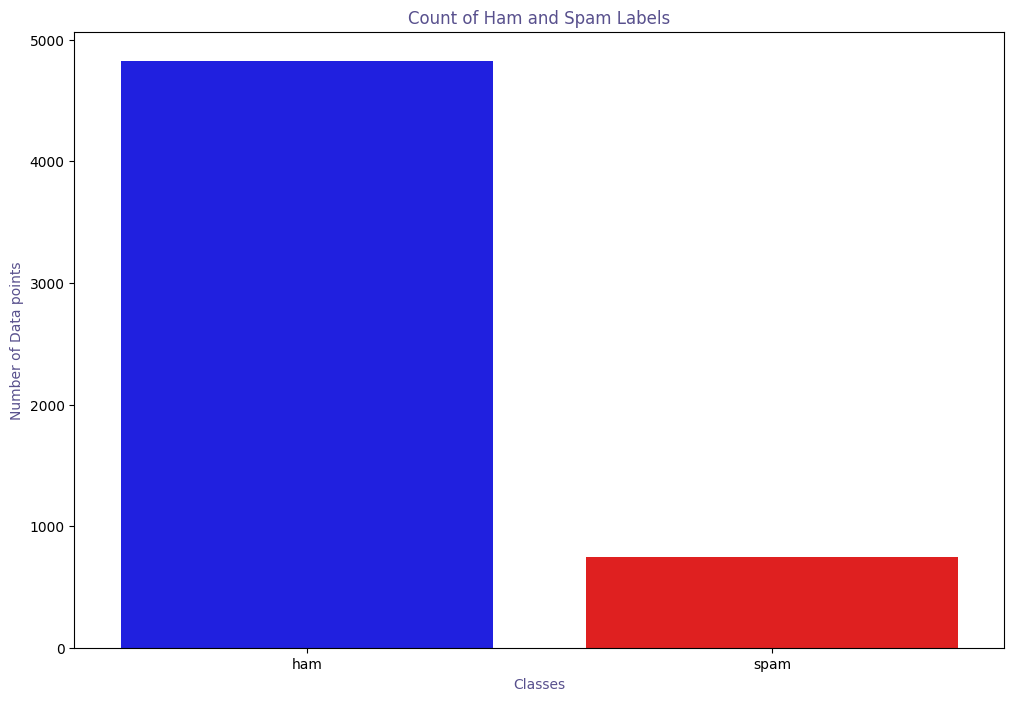

In [7]:
#Palette
cols= ["blue", "red"]
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= messages["label"], palette= cols)
fg.set_title("Count of Ham and Spam Labels", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d");

# Removing Stopwords and Punctuation

In [8]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)

    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# Splitting Data Into Train and Test Sets

In [9]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'],
                     messages['label'],
                     test_size=0.2,
                     random_state=42)

# Creating Models

## Support Vector Classifier

In [10]:
random.seed(620)
# Make the pipeline for iterative testing.
svc_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC())  # train on TF-IDF vectors w/ SVM classifier
])

In [11]:
random.seed(620)
#use pipeline to fit the training messages
svc_pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7e52afb59440>)),
                ('tfidf', TfidfTransformer()), ('classifier', SVC())])

In [12]:
random.seed(620)
svc_predictions = svc_pipeline.predict(msg_test)

In [13]:
print(classification_report(svc_predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98       996
        spam       0.79      0.99      0.88       119

    accuracy                           0.97      1115
   macro avg       0.89      0.98      0.93      1115
weighted avg       0.98      0.97      0.97      1115



In [14]:
print(confusion_matrix(svc_predictions,label_test))

[[964  32]
 [  1 118]]


### Confusion Matrix Test Set

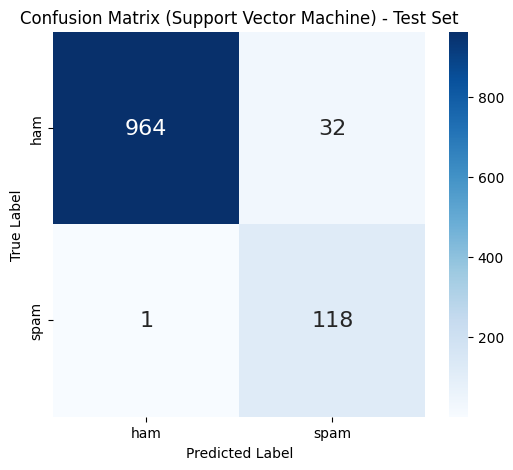

In [15]:
# Create confusion matrix
cm_test_svc = confusion_matrix(svc_predictions, label_test, labels=["ham", "spam"])

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_test_svc, annot=True, fmt="d", cmap="Blues", xticklabels=["ham", "spam"], yticklabels=["ham", "spam"], annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Support Vector Machine) - Test Set")
plt.show()

## Random Forest Classifier

In [16]:
random.seed(620)
# Make the pipeline for iterative testing.
rf_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier())  # train on TF-IDF vectors w/ Random Forest classifier
])

In [17]:
random.seed(620)
#use pipeline to fit the training messages
rf_pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7e52afb59440>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [18]:
random.seed(620)
rf_predictions = rf_pipeline.predict(msg_test)

In [19]:
print(classification_report(rf_predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98       996
        spam       0.79      1.00      0.88       119

    accuracy                           0.97      1115
   macro avg       0.90      0.98      0.93      1115
weighted avg       0.98      0.97      0.97      1115



In [20]:
print(confusion_matrix(rf_predictions,label_test))

[[965  31]
 [  0 119]]


### Confusion Matrix Test Set

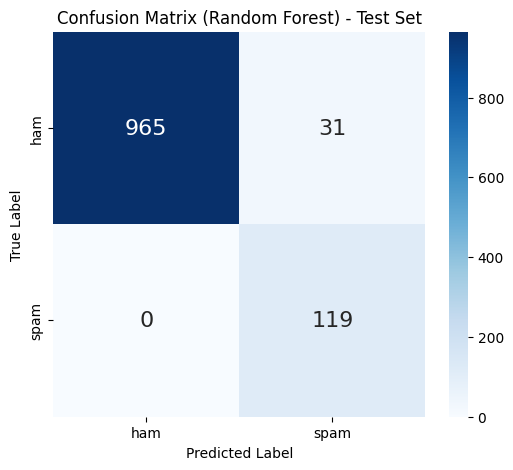

In [21]:
# Create confusion matrix
cm_test_rf = confusion_matrix(rf_predictions, label_test, labels=["ham", "spam"])

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_test_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["ham", "spam"], yticklabels=["ham", "spam"], annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Random Forest) - Test Set")
plt.show()

## Naive Bayes Classifier

In [22]:
random.seed(620)
# Make the pipeline for iterative testing.
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB())  # train on TF-IDF vectors w/ Random Forest classifier
])

In [23]:
random.seed(620)
#use pipeline to fit the training messages
nb_pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7e52afb59440>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [24]:
random.seed(620)
nb_predictions = nb_pipeline.predict(msg_test)

In [25]:
print(classification_report(nb_predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1003
        spam       0.75      1.00      0.85       112

    accuracy                           0.97      1115
   macro avg       0.87      0.98      0.92      1115
weighted avg       0.97      0.97      0.97      1115



In [26]:
print(confusion_matrix(nb_predictions,label_test))

[[965  38]
 [  0 112]]


### Confusion Matrix Test Set

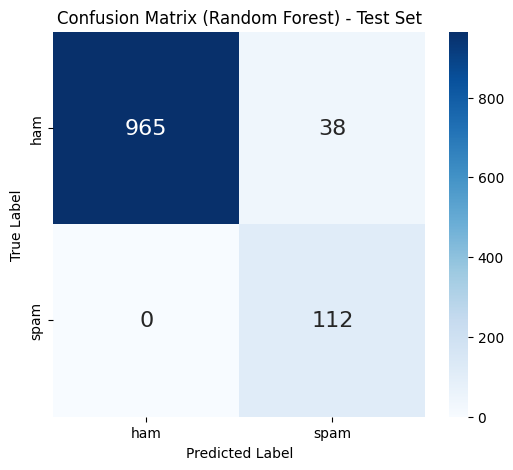

In [27]:
# Create confusion matrix
cm_test_nb = confusion_matrix(nb_predictions, label_test, labels=["ham", "spam"])

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_test_nb, annot=True, fmt="d", cmap="Blues", xticklabels=["ham", "spam"], yticklabels=["ham", "spam"], annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Random Forest) - Test Set")
plt.show()

# Model Metrics

In [28]:
models = {
    "SVC": svc_predictions,
    "Random Forest": rf_predictions,
    "Naive Bayes": nb_predictions,
}

In [29]:
# Initialize a list to store metrics
metrics = []

# Loop through each model's predictions
for name, preds in models.items():
    metrics.append({
        'Model': name,
        'Accuracy': accuracy_score(label_test, preds),
        'Precision': precision_score(label_test, preds, pos_label='spam'),
        'Recall': recall_score(label_test, preds, pos_label='spam'),
        'F1 Score': f1_score(label_test, preds, pos_label='spam')
    })

# Create a DataFrame from the list of dictionaries
metrics_df = pd.DataFrame(metrics)

# # Melt for visualization
# metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# # Plot
# plt.figure(figsize=(10, 6))
# sns.barplot(data=metrics_melted, x='Metric', y='Score', hue='Model')
# plt.title("Model Performance Comparison")
# plt.ylim(0, 1)
# plt.legend(title='Model')
# plt.show()

In [30]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,SVC,0.970404,0.991597,0.786667,0.877323
1,Random Forest,0.972197,1.000000,0.793333,0.884758
2,Naive Bayes,0.965919,1.000000,0.746667,0.854962


In [31]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
metrics_df.style.background_gradient(cmap=cmap2)

,Model,Accuracy,Precision,Recall,F1 Score
0,SVC,0.970404,0.991597,0.786667,0.877323
1,Random Forest,0.972197,1.000000,0.793333,0.884758
2,Naive Bayes,0.965919,1.000000,0.746667,0.854962


# Observation and Final Insights

After splitting the spam dataset into training and test data, the data went through three classifier models; Support Vector Classifer, Random Forest Classifier and Naive Bayes Classifer. The goal is to determine which classifer is the best. Each of the models had high accuracy. Random Forest had the highest accuracy at 97.2%, followed by SVC with 97% and Naive Bayes with 96.6%. Random Forest also had the highest f1 score, at 88.5%, followed by SVC with 88.7% and Naive Bayes with 85.5%. While each of the models performed very well in detecting spam, Random Forest performed slightly better.